In [1]:
#pip install liana

import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython
import pandas as pd
import anndata

sc.settings.figdir=os.path.expanduser('~/WbFigures/DevSignaling')
sc._settings.settings._vector_friendly=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *

gs1=matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102,name='godsnot_102')
try:
    matplotlib.colormaps.register(name='godsnot_102',cmap=gs1)
except:
    pass


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is not available


In [2]:
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
leaf_key='level_2'
MDE_KEY = "X_antipode_UMAP"
anndata.settings.allow_write_nullable_strings = True

model_tag   = '1.9.1.8.5_Dev_final_looser'
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag
adata = sc.read_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))
antipode_model=antipode.antipode_model.ANTIPODE.load(model_path,adata=adata,prefix='p3_',device=device)
antipode_model.save_params_to_uns()
adata=antipode_model.adata_manager.adata
pstore = adata.uns['param_store']

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [3]:
pstore = adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=antipode_model.calculate_cluster_params(flavor='numpy')
keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
cluster_labels = np.array(cluster_labels)[keep_clusters]
zero_mask = zero_mask[:,keep_clusters,:]
cluster_index = np.array([int(x) for x in cluster_labels])
zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_locs = prop_locs[cluster_index,:]
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[antipode_model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=antipode_model.level_sizes[-1]

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:447: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:448: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [4]:
# aggr_means=antipode.model_functions.group_aggr_anndata(adata,['species','level_2'],layer='spliced',normalize=True)
# log_real_means=antipode.model_functions.safe_log_transform(aggr_means[0]) # #species,#cluster,#genes array

In [5]:
# centered_discov_cluster_params=discov_cluster_params-discov_cluster_params.mean(0)
# centered_aggr_means=log_real_means-log_real_means.mean(0)

In [6]:
# l1p_aggr=antipode.model_functions.group_aggr_anndata(adata,['level_2'])
# l1p_aggr_class=antipode.model_functions.group_aggr_anndata(adata,['curated_class_label'])


In [8]:
log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,'Subclass_markers',layer=layer_key)
real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels['Subclass_markers'])
real_means=real_means.loc[real_mean_levels['Subclass_markers'],:]

100%|██████████| 79/79 [03:59<00:00,  3.03s/it]


In [9]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif']='DejaVuSansMono'
plt.rcParams['pdf.fonttype']=42


In [10]:
div_markers={'G0':list(set([])),#'YWHAG','NNAT'
             'G1':list(set(['CCND1','CCND2','CCND3','CCNE1','CCNE2','MKI67','PCNA'])),
'G1S':list(set(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
      'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'RAD51AP1', 'GMNN', 
      'WDR76', 'SLBP', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 
      'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 
      'E2F8','H4C3','H1-3','H1-5','H2AC12','H2AC20','H1-2','H1-4','H1-1','FBXO5',
      'SPC25','FAM83D','HIST1H1A','HIST1H1B','HIST1H1C','HIST1H1D','HIST1H1E','CCND1','CCND2','CCND3'])),#,'CCNE1', 'CCNE2'
'G2M':list(set(['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 
       'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 
       'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 
       'GAS2L3', 'CBX5','ASPM','CENPA','CCND1','CCND2','CCND3']))
        }

gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
rl_genes=pd.read_csv(os.path.join(gl_path,'MTS_neuropeptides_receptors.tsv'),sep='\t')
rl_genes['type'] = rl_genes['type'].str.split(',')
rl_genes = rl_genes.explode('type')


In [11]:
# pseudobulk=pd.DataFrame(discov_cluster_params.mean(0),columns=adata.var.index)
pseudobulk=pd.DataFrame(real_means,columns=adata.var.index)
sl_pseudobulk = np.exp(pseudobulk-pseudobulk.max(0)) #scaled linear-space pseudobulk

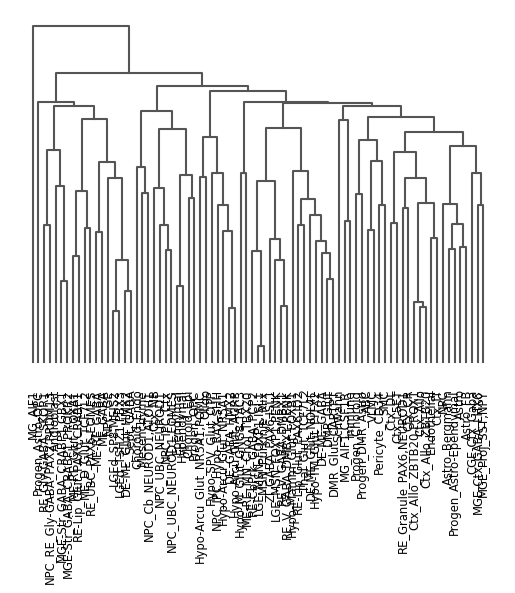

<Axes: >

In [12]:
sc.tl.dendrogram(adata,groupby='Subclass_markers',use_rep="X_antipode",linkage_method='average')
sc.pl.dendrogram(adata,groupby='Subclass_markers')

In [15]:
sl_pseudobulk = sl_pseudobulk.iloc[adata.uns[f'dendrogram_Subclass_markers']['categories_idx_ordered'],:]

In [16]:
sl_pseudobulk

,TRAPPC2,C17orf49,C2orf68,C4orf19,C4orf54,C11orf58,C9orf24,C11orf1,C3orf80,C8orf33,...,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ASIP,CCDC198
Oligo,0.795095,0.362554,0.682731,0.048839,0.138674,0.805514,0.000270,0.266480,0.045850,0.912971,...,0.372568,0.074643,0.058466,0.587022,0.085499,0.296985,0.175296,0.916970,0.015500,0.047732
RE_V_GABA_DMBX1,0.883214,0.525301,0.748198,0.019237,0.242973,0.793948,0.003091,0.465571,0.197678,0.939373,...,0.568078,0.119321,0.048941,0.653398,0.211884,0.653068,0.127479,0.560737,0.021244,0.060375
Ctx_NB,0.639372,0.400439,0.702071,0.029761,0.174558,0.724078,0.000911,0.326661,0.048406,0.907286,...,0.428492,0.146539,0.100797,1.000000,0.169728,0.491143,0.149798,0.518431,0.014477,0.053903
Progen_DMR_Astro,0.559008,0.310919,1.000000,0.030548,0.073550,0.757810,0.023391,0.532927,0.029998,0.983971,...,0.637412,0.447186,0.334302,0.409673,0.054112,0.216756,0.230667,0.346886,0.008359,0.499698
Progen_OPC,0.714153,0.532851,0.751426,0.395348,0.191908,0.689879,0.001003,0.253591,0.139923,0.985409,...,0.650927,0.420449,0.328837,0.700381,0.129371,0.474515,0.306568,0.628272,0.016165,0.152363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE_GABA_HMX2,0.928893,0.451863,0.608111,0.019536,0.181903,0.921165,0.003702,0.541237,0.083411,0.620716,...,0.356019,0.107603,0.027684,0.473971,0.258772,0.637408,0.095831,0.483648,0.021053,0.080274
"Hypo_M_Glut_GNG8,TAC3",0.615374,0.432484,0.504167,0.013833,0.138938,0.701323,0.002698,0.397430,0.116501,0.948504,...,0.277824,0.089283,0.016729,0.581920,0.243197,0.743320,0.123919,0.636768,0.022598,0.027113
Pericyte_CD34,0.368434,0.505615,0.840839,0.025475,0.185418,0.516868,0.000415,0.165064,0.117595,0.624153,...,0.453418,0.280542,0.124780,0.434022,0.093649,0.220514,0.601554,0.530744,0.029549,0.039711
Progen_Astro-Ependymal,0.532984,0.358634,0.572763,0.332718,0.167421,0.502219,0.119214,0.546177,0.209342,0.937318,...,0.450184,0.165250,0.115921,0.585050,0.123041,0.286272,0.199592,0.394440,0.016284,1.000000


In [17]:
rl_genes=rl_genes.loc[:,['hgnc_symbol','gene_class','type','complex']]
print(rl_genes['gene_class'].unique())
np_genes=rl_genes.loc[rl_genes['gene_class'].isin(['Synthesis','Neuropeptide']),:]
receptors = np_genes[np_genes['type'].str.endswith('-receiving')]
ligands = np_genes[~np_genes['type'].str.endswith('-receiving')]
receptors['complex']=receptors['complex'].fillna(receptors['hgnc_symbol'])
receptors = receptors.groupby(['complex', 'type','gene_class'])['hgnc_symbol'].apply('_'.join).reset_index()

# Map receptors to ligands
results = []
for index, receptor in receptors.iterrows():
    ligand_type = receptor['type'].replace('-receiving', '')
    ligand = ligands[ligands['type'] == ligand_type]
    if not ligand.empty:
        results.append({
            'ligand': ligand.iloc[0]['hgnc_symbol'],
            'receptor': receptor['hgnc_symbol']
        })
    else:
        print(receptor)
        pass
        #print(ligand_type)

# Convert results to DataFrame
ligands_receptors = pd.DataFrame(results)

# Resetting index for a clean look similar to the one asked
ligands_receptors.reset_index(drop=True, inplace=True)
ligands_receptors=ligands_receptors.astype('string')
print(ligands_receptors)


['Receptor' 'Transporter' 'Synthesis' 'TF' 'Neuropeptide']
complex                  GRM3
type           NAAG-receiving
gene_class       Neuropeptide
hgnc_symbol              GRM3
Name: 23, dtype: object
     ligand   receptor
0   ADCYAP1  ADCYAP1R1
1       AVP     AVPR1A
2       AVP     AVPR1B
3       AVP      AVPR2
4      KNG1     BDKRB1
..      ...        ...
88     TAC1      TACR3
89      TRH      TRHR1
90      TRH      TRHR2
91      VIP      VIPR1
92      VIP      VIPR2

[93 rows x 2 columns]


/scratch/fast/438639/ipykernel_3205998/2075812134.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  receptors['complex']=receptors['complex'].fillna(receptors['hgnc_symbol'])


In [18]:
from statsmodels.stats.multitest import multipletests

import numpy as np
import pandas as pd
import tqdm

def calculate_interaction_scores(expr, pairs, n_iter=1000, random_state=None):
    """
    Calculate integration scores and permutation-based significance p-values for
    receptor-ligand interactions between clusters.

    For each ligand (and its receptors) present in the expression DataFrame, we compute:
      - Observed score: outer(L, R_mean) where L is the ligand expression (per cluster)
        and R_mean is the mean receptor expression across valid receptors (per cluster).
      - P-values: For each cell in the observed matrix, the p-value is computed as the
        fraction of products (sampled from the null distribution) that are greater than or
        equal to the observed value.

    The null distribution is defined globally by taking all expression values for genes
    that appear as either a ligand or receptor in the `pairs` DataFrame and multiplying
    pairs of them together. This same null distribution is used for all ligands.

    Parameters
    ----------
    expr : pandas.DataFrame
        Rows are clusters and columns are gene names (scaled expression values).
    pairs : pandas.DataFrame
        Must contain columns 'ligand' and 'receptor' with receptor-ligand pairs.
    n_iter : int, optional
        Number of samples for the null distribution (default is 1000).
    random_state : int or None, optional
        Random seed for reproducibility.

    Returns
    -------
    interaction_scores : dict
        Dictionary mapping each ligand to its observed interaction score matrix (n_clusters x n_clusters).
    p_values : dict
        Dictionary mapping each ligand to its corresponding p-value matrix (n_clusters x n_clusters).
    """
    rng = np.random.default_rng(random_state)
    interaction_scores = {}
    p_values = {}
    clusters = expr.index.values
    n_clusters = len(clusters)

    # Build a global pool from all relevant genes (appearing as ligand or receptor) that are present in expr.
    all_genes = set(pairs['ligand']).union(set(pairs['receptor']))
    valid_genes = [g for g in all_genes if g in expr.columns]
    global_pool = expr[valid_genes].values.flatten()

    # Generate a global null distribution:
    # Each sample is the product of two values drawn at random from the global pool.
    x_samples = rng.choice(global_pool, size=n_iter)
    y_samples = rng.choice(global_pool, size=n_iter)
    null_distribution = x_samples * y_samples  # shape: (n_iter,)

    # Process each ligand group.
    for ligand, group in tqdm.tqdm(pairs.groupby('ligand')):
        if ligand not in expr.columns:
            continue  # skip ligands not present in expr

        # Get unique receptors for this ligand that are present in expr.
        receptors = group['receptor'].unique()
        valid_receptors = [r for r in receptors if r in expr.columns]
        if not valid_receptors:
            continue

        # Observed ligand and receptor expressions.
        L = expr[ligand].values  # shape: (n_clusters,)
        R = np.column_stack([expr[r].values for r in valid_receptors])  # shape: (n_clusters, m)
        R_mean = R.mean(axis=1)  # shape: (n_clusters,)
        observed = np.outer(L, R_mean)  # shape: (n_clusters, n_clusters)

        # For each cell in the observed matrix, compute p-value as the fraction of samples in the
        # global null distribution that are greater than or equal to the observed value.
        # Broadcasting: null_distribution[:, None, None] has shape (n_iter, 1, 1) and observed has shape (n_clusters, n_clusters).
        p_matrix = (np.sum(null_distribution[:, None, None] >= observed[None, :, :], axis=0) + 1) / (n_iter + 1)

        interaction_scores[ligand] = observed
        p_values[ligand] = p_matrix

    return interaction_scores, p_values



def adjust_pvalues_matrix(p_matrix, alpha=0.001, method='fdr_bh'):
    """
    Adjust a matrix of p-values using multiple testing correction.

    Parameters
    ----------
    p_matrix : np.ndarray
        A 2D array of p-values.
    alpha : float, optional
        The significance level to control the FDR (default: 0.001).
    method : str, optional
        The method for correction (default: 'fdr_bh' for Benjamini–Hochberg).

    Returns
    -------
    p_adjusted : np.ndarray
        The matrix of adjusted p-values (same shape as p_matrix).
    reject : np.ndarray
        A boolean matrix indicating which tests are significant.
    """
    # Flatten the matrix to apply correction on all p-values at once.
    p_flat = p_matrix.flatten()
    
    # Apply the multiple testing correction.
    reject, pvals_corrected, _, _ = multipletests(p_flat, alpha=alpha, method=method)
    
    # Reshape back to the original matrix shape.
    p_adjusted = pvals_corrected.reshape(p_matrix.shape)
    reject = reject.reshape(p_matrix.shape)
    
    return p_adjusted, reject


In [28]:
ccl_neighborhood_dict = adata.obs.groupby('Neighborhood')['Subclass_markers'].value_counts().unstack().idxmax(0).to_dict()

/scratch/fast/438639/ipykernel_3205998/282739488.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ccl_neighborhood_dict = adata.obs.groupby('Neighborhood')['Subclass_markers'].value_counts().unstack().idxmax(0).to_dict()


In [29]:
level2_ccl_dict = adata.obs.groupby('Subclass_markers')['level_2'].value_counts().unstack().idxmax(0).to_dict()

/scratch/fast/438639/ipykernel_3205998/9835272.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  level2_ccl_dict = adata.obs.groupby('Subclass_markers')['level_2'].value_counts().unstack().idxmax(0).to_dict()


In [30]:
neighborhoods = sl_pseudobulk.index.to_series().replace(ccl_neighborhood_dict)

In [31]:
(adata.obs.groupby('Subclass_markers')['level_2'].value_counts().unstack()>3).sum(1)

/scratch/fast/438639/ipykernel_3205998/3124164008.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (adata.obs.groupby('Subclass_markers')['level_2'].value_counts().unstack()>3).sum(1)


Subclass_markers
DE-ME_GABA                    5
DE-ME_Glut_HMX2               1
DE-ME_Glut_NOL4L              2
DE_GABA_HMX2                  1
DMR_Glut                      9
                             ..
MGE-Str_GABA_CRABP1,GBX1      1
MGE-Str_GABA_CRABP1,PROKR2    1
MGE_Proj_SST,NPY              2
MSN_Purkinje_Mix              3
RE_V_GABA_DMBX1,PENK          1
Length: 79, dtype: int64

In [32]:
(adata.obs.groupby('Class')['Subclass_markers'].value_counts().unstack()>3).sum(1)

/scratch/fast/438639/ipykernel_3205998/3136654883.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (adata.obs.groupby('Class')['Subclass_markers'].value_counts().unstack()>3).sum(1)


Class
DE-ME_GABA     7
DE-ME_Glut    10
DMR_Glut       4
Motor          1
RE_GABA        3
RL_Glut        4
MG             2
Astro          4
Choroid        3
Ependymal      1
GPC            5
Oligo          2
Immune         1
Vascular       7
NPC            8
CGE            1
Ctx_Glut       8
LGE            6
MGE            4
dtype: int64

In [33]:
#group by Class
#group level_2 by Subclass_markers
#Order by Subclass_markers
#Plot mega heatmap
#Plot 


In [34]:
interaction_scores, p_values = calculate_interaction_scores(sl_pseudobulk, ligands_receptors, n_iter=int(1e4), random_state=13)

100%|██████████| 42/42 [00:15<00:00,  2.75it/s]


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm

def plot_tile_heatmap(data, dim_0_names, dim_1_names, dim_2_names, mini_grid_dims=None, 
                      cell_size=1, cmap_name='tab20', heavy_linewidth=2, light_linewidth=0.2,save_path=None):
    """
    Plot a nested heatmap where each cell (grid pair) is subdivided into mini tiles
    representing ligand–receptor interaction strengths, and adds a legend for ligands.
    
    Parameters
    ----------
    data : np.ndarray
        3D array of shape (n_rows, n_cols, n_ligands) with values in [0, 1].
    dim_0_names : list of str
        Labels for the rows (y-axis). Length should equal n_rows.
    dim_1_names : list of str
        Labels for the columns (x-axis). Length should equal n_cols.
    dim_2_names : list of str
        Names for each ligand (used to assign colors and for the legend).
    mini_grid_dims : tuple of ints, optional
        Dimensions (rows, cols) of the mini grid inside each cell. If None, the grid
        will be as square as possible.
    cell_size : float, optional
        The size of each cell in the heatmap.
    cmap_name : str, optional
        Name of a qualitative colormap (e.g. 'tab20') to assign each ligand a unique base color.
    heavy_linewidth : float, optional
        Line width for the boundaries between cells.
    light_linewidth : float, optional
        Line width for the subgrid (mini-tile) borders.
    """
    n_rows_data, n_cols_data, n_ligands = data.shape

    # Validate that provided labels match the data dimensions.
    if len(dim_0_names) != n_rows_data:
        raise ValueError(f"Expected {n_rows_data} row labels (dim_0_names), but got {len(dim_0_names)}.")
    if len(dim_1_names) != n_cols_data:
        raise ValueError(f"Expected {n_cols_data} column labels (dim_1_names), but got {len(dim_1_names)}.")

    # Determine mini-grid dimensions (rows x cols) for subdividing each cell.
    if mini_grid_dims is None:
        n_rows = int(np.floor(np.sqrt(n_ligands)))
        n_rows = max(n_rows, 1)
        n_cols = int(np.ceil(n_ligands / n_rows))
    else:
        n_rows, n_cols = mini_grid_dims

    # Get base colors for each ligand using the specified qualitative colormap.
    cmap = plt.get_cmap(cmap_name)
    base_colors = [cmap(i / n_ligands) for i in range(n_ligands)]
    
    # Create figure and axis.
    fig, ax = plt.subplots(figsize=(n_cols_data * cell_size, n_rows_data * cell_size))
    ax.set_xlim(0, n_cols_data * cell_size)
    ax.set_ylim(0, n_rows_data * cell_size)
    ax.set_aspect('equal')
    # Invert y-axis so that the first row appears at the top.
    ax.invert_yaxis()
    
    # Loop over each cell in the grid.
    for i in tqdm.tqdm(range(n_rows_data)):
        for j in range(n_cols_data):
            cell_x = j * cell_size
            cell_y = i * cell_size
            # Draw heavy border for the cell.
            ax.add_patch(patches.Rectangle((cell_x, cell_y), cell_size, cell_size, 
                                           fill=False, edgecolor='black', lw=heavy_linewidth))
            # Dimensions of each mini-tile.
            tile_w = cell_size / n_cols
            tile_h = cell_size / n_rows
            # Loop over each ligand (mini-tile).
            for k in range(n_ligands):
                mini_row = k // n_cols
                mini_col = k % n_cols
                tile_x = cell_x + mini_col * tile_w
                # Remove the inversion of mini_row to flip the order relative to the legend.
                tile_y = cell_y + mini_row * tile_h
                v = data[i, j, k]
                base = np.array(base_colors[k][:3])  # Drop alpha if present.
                color = (1 - v) * np.array([1, 1, 1]) + v * base
                ax.add_patch(patches.Rectangle((tile_x, tile_y), tile_w, tile_h, 
                                               facecolor=color, edgecolor='gray', lw=light_linewidth))
    
    # Set tick positions: columns on x-axis and rows on y-axis.
    xticks = np.arange(cell_size/2, n_cols_data * cell_size, cell_size)
    yticks = np.arange(cell_size/2, n_rows_data * cell_size, cell_size)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    # For rectangular grids, use dim_1_names for x-axis (columns) and dim_0_names for y-axis (rows).
    ax.set_xticklabels(dim_1_names,rotation=90)
    ax.set_yticklabels(dim_0_names)
    
    # Create a legend with color patches for each ligand.
    legend_handles = [patches.Patch(color=base_colors[k], label=dim_2_names[k]) 
                      for k in range(n_ligands)]
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Ligands')
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()


100%|██████████| 47/47 [01:12<00:00,  1.54s/it]


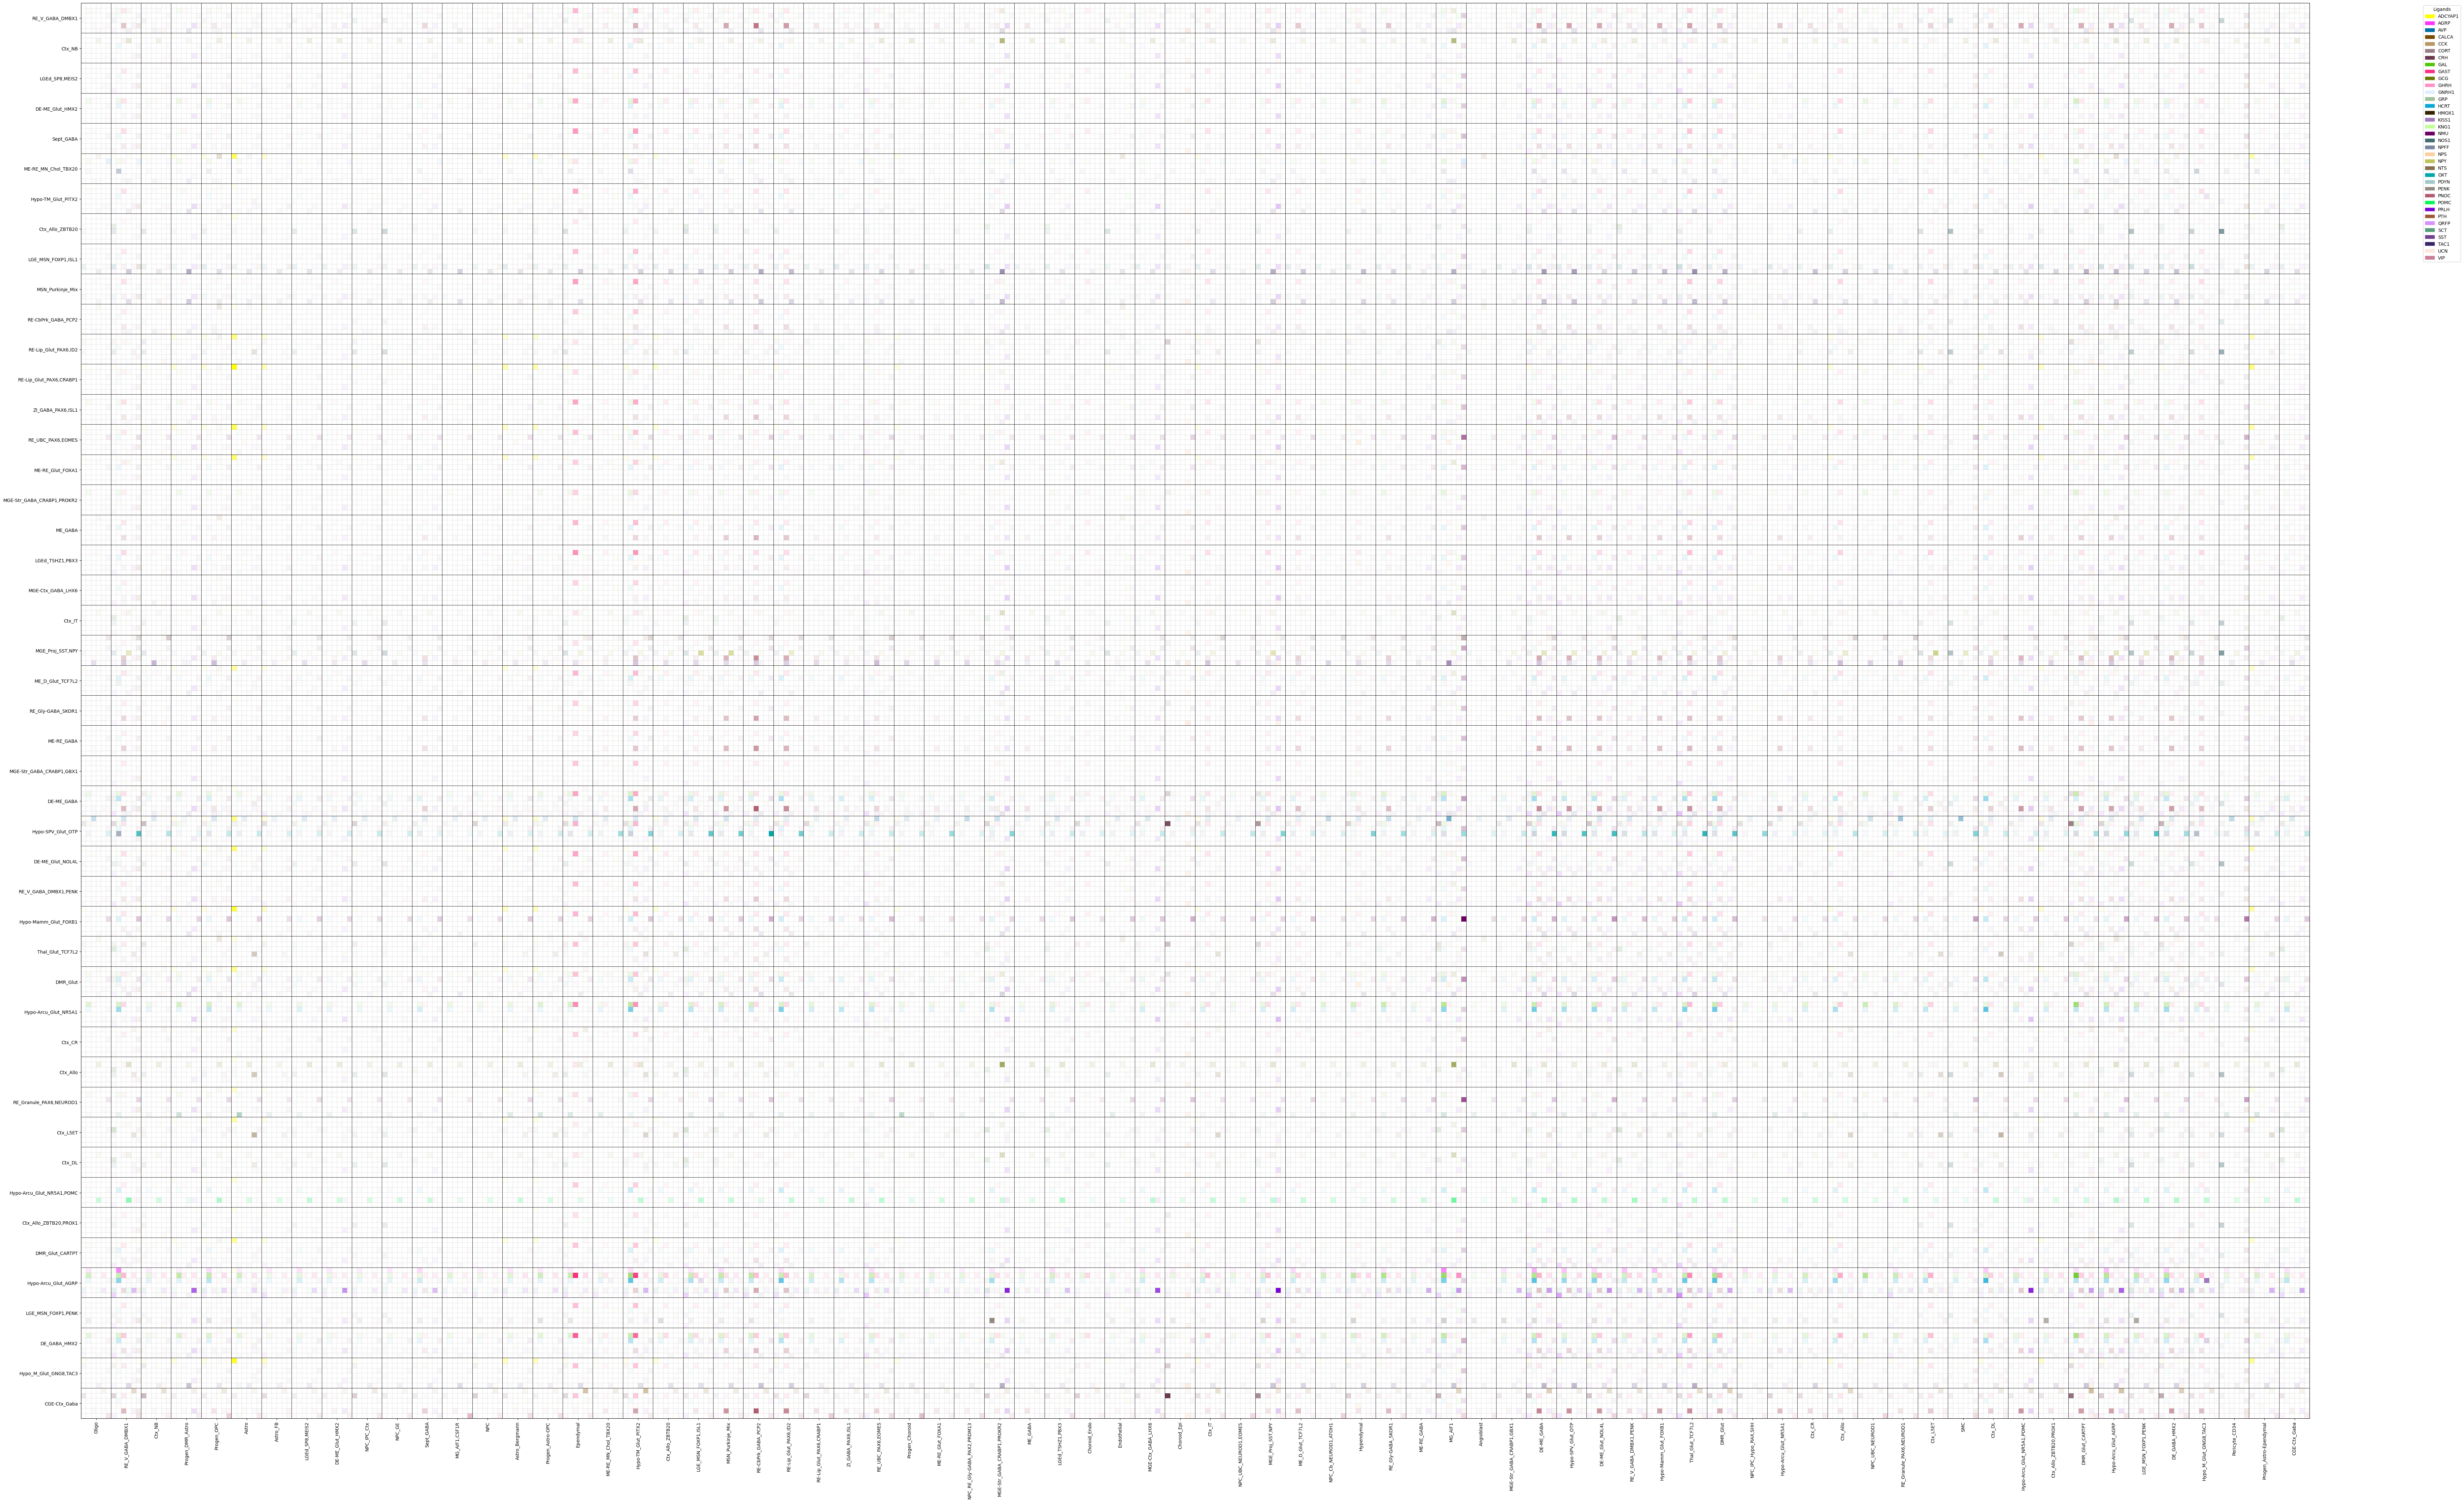

In [36]:
ligand_names = list(interaction_scores.keys())
score_tensor = np.stack(list(interaction_scores.values()),-1)
plot_tile_heatmap(score_tensor[neighborhoods.isin(['T','DMR']),...][:,neighborhoods!='Neighbor',:],
                  dim_0_names=list(sl_pseudobulk.index[neighborhoods.isin(['T','DMR'])]),
                  dim_1_names=list(sl_pseudobulk.index[neighborhoods!='Neighbor']),
                  dim_2_names=ligand_names,
                  cell_size=1,heavy_linewidth=2,light_linewidth=0.1,cmap_name='godsnot_102',save_path=os.path.join(sc.settings.figdir,'Ligand-Receptor_megaheatmap.pdf'))

In [40]:
import xarray as xr


# species_means,species_means_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,'Subclass_markers',layer=layer_key)

species_scaled = xr.DataArray(np.exp(species_means-species_means.max(0).max(0)),coords={'species':species_means_levels['species'],'Subclass_markers':species_means_levels['Subclass_markers'],'var':adata.var.index})
species_differences = xr.DataArray(species_means-species_means.mean(0),coords={'species':species_means_levels['species'],'Subclass_markers':species_means_levels['Subclass_markers'],'var':adata.var.index})
receptor_differences = species_differences.sel({'var':list(ligands_receptors['receptor'][ligands_receptors['receptor'].isin(adata.var.index)].unique()),'Subclass_markers':list(sl_pseudobulk.index[neighborhoods!='Neighbor'])})
ligand_differences = species_differences.sel({'var':ligand_names,'Subclass_markers':list(sl_pseudobulk.index[neighborhoods.isin(['T','DMR'])])})

In [41]:
species_scaled

<xarray.DataArray (species: 3, Subclass_markers: 79, var: 16738)> Size: 32MB
array([[[0.31161143, 0.09042561, 0.42707553, ..., 0.08916876,
         0.00225998, 0.01420685],
        [0.31780567, 0.03062576, 0.4728903 , ..., 0.03418699,
         0.00273737, 0.0055139 ],
        [0.34172754, 0.04239038, 0.52924335, ..., 0.11875036,
         0.00353157, 0.02087218],
        ...,
        [0.32958281, 0.09989709, 0.34399396, ..., 0.13907974,
         0.00298827, 0.00601929],
        [0.28591753, 0.15950866, 0.29902685, ..., 0.08526164,
         0.00468513, 0.00577948],
        [0.32607817, 0.09857083, 0.50617422, ..., 0.13708485,
         0.01013424, 0.01261289]],

       [[0.23808983, 0.04281396, 0.02929895, ..., 0.18738907,
         0.00488229, 0.01605423],
        [0.20132776, 0.02017074, 0.03788224, ..., 0.08302145,
         0.00273737, 0.0055139 ],
        [0.20416562, 0.04387965, 0.05145572, ..., 0.2488441 ,
         0.00353157, 0.10460683],
...
        [0.28490785, 0.0422137 , 0.03877949, ..., 0.22971333,
         0.00298827, 0.00601929],
        [0.23923804, 0.05303471, 0.02904684, ..., 0.15454677,
         0.00286921, 0.00577948],
        [0.24126712, 0.03848063, 0.04610804, ..., 0.18240188,
         0.00379841, 0.00765116]],

       [[0.66637319, 0.29661649, 0.04740568, ..., 0.15690104,
         0.00225998, 0.00752771],
        [0.84065818, 0.29847667, 0.07763931, ..., 0.16437999,
         0.00273737, 0.0055139 ],
        [0.48280201, 0.23401098, 0.08604447, ..., 0.2755429 ,
         0.00353157, 0.00711366],
        ...,
        [0.36816929, 0.23263284, 0.05687696, ..., 0.17631969,
         0.00628663, 0.00741117],
        [0.40081656, 0.38839568, 0.06878062, ..., 0.18488961,
         0.00286921, 0.00801791],
        [0.58823063, 0.29153061, 0.08425939, ..., 0.1666522 ,
         0.00379841, 0.01929203]]])
Coordinates:
  * species           (species) <U7 84B 'human' 'macaque' 'mouse'
  * Subclass_markers  (Subclass_markers) <U27 9kB 'DE-ME_GABA' ... 'RE_V_GABA...
  * var               (var) object 134kB 'TRAPPC2' 'C17orf49' ... 'CCDC198'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_tricolor_heatmap(data, x_tick_labels=None, y_tick_labels=None,color_axes=['Blue','Red','Yellow'],
                          heatmap_figsize=(10, 4), legend_figsize=(6, 6),save_prefix=None):
    """
    Plots a tricolor (RBY) heatmap using the mapping:
      R = 1 - a
      G = 1 - (a + b)
      B = 1 - (b + c)
    where data is a (3, height, width) array. This mapping gives:
      [max, 0, 0] -> blue   (0,0,1)
      [0, max, 0] -> red    (1,0,0)
      [0, 0, max] -> yellow (1,1,0)
    with white at [0,0,0] and black at [max,max,max].
    
    It also creates a ternary legend (in a separate figure) illustrating the 
    color gradient with the vertices labeled.
    
    Parameters:
      data            : np.array of shape (3, height, width)
      x_tick_labels   : list/array of x-axis tick labels (rotated 90°)
      y_tick_labels   : list/array of y-axis tick labels
      heatmap_figsize : tuple for the heatmap figure size (default (10,4))
      legend_figsize  : tuple for the legend figure size (default (6,6))
    """
    # -----------------------------
    # Part 1: Create and plot the tricolor heatmap
    # -----------------------------
    # Normalize the data so that the maximum value is 1.
    data_norm = data / np.max(data)
    
    # Unpack channels:
    a = data_norm[0, :, :]  # will control blue
    b = data_norm[1, :, :]  # will control red
    c = data_norm[2, :, :]  # will control yellow
    
    # Mapping from (a, b, c) to RGB:
    #   [max, 0, 0] (a=1)  -> blue:   (0,0,1)
    #   [0, max, 0] (b=1)  -> red:    (1,0,0)
    #   [0, 0, max] (c=1)  -> yellow: (1,1,0)
    # with white at [0,0,0] and black at [max, max, max].
    R = 1 - a
    G = 1 - (a + b)
    B = 1 - (b + c)
    
    # Clip values to ensure valid RGB in [0,1]
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)
    
    # Form the image with shape (height, width, 3)
    img = np.stack([R, G, B], axis=2)
    
    plt.figure(figsize=heatmap_figsize)
    plt.imshow(img)
    plt.title("Tricolor Heatmap (RBY)")
    if x_tick_labels is not None:
        plt.xticks(ticks=np.arange(len(x_tick_labels)), labels=x_tick_labels, rotation=90)
    if y_tick_labels is not None:
        plt.yticks(ticks=np.arange(len(y_tick_labels)), labels=y_tick_labels)
    else:
        plt.yticks([])
    plt.tight_layout()
    if save_prefix is not None:
        plt.savefig(save_prefix+'_heatmap.pdf')
    plt.show()
    
    # -----------------------------
    # Part 2: Create a triangular (ternary) legend
    # -----------------------------
    # The legend shows a ternary plot where each vertex corresponds to:
    #   (a=1, b=0, c=0) -> blue   (0,0,1)
    #   (a=0, b=1, c=0) -> red    (1,0,0)
    #   (a=0, b=0, c=1) -> yellow (1,1,0)
    def project(a, b, c):
        # Center the point by subtracting the mean (to handle translation invariance)
        mu = (a + b + c) / 3.0
        a_prime = a - mu
        b_prime = b - mu
        c_prime = c - mu
        # Apply affine projection:
        #   T(1,0,0) -> (0, 1)   [blue]
        #   T(0,1,0) -> (sqrt3/2, -1/2)  [red]
        #   T(0,0,1) -> (-sqrt3/2, -1/2) [yellow]
        x = (np.sqrt(3) / 2) * (b_prime - c_prime)
        y = a_prime - 0.5 * (b_prime + c_prime)
        return x, y
    
    # Generate many points uniformly in the simplex S (a+b+c <= 1)
    N = 500000  # number of random points for a smooth legend
    points = []
    colors = []
    for _ in range(N):
        pt = np.random.rand(3)
        if pt.sum() <= 1:
            a_pt, b_pt, c_pt = pt
            # Compute color according to RBY mapping:
            R_pt = 1 - a_pt
            G_pt = 1 - (a_pt + b_pt)
            B_pt = 1 - (b_pt + c_pt)
            R_pt = np.clip(R_pt, 0, 1)
            G_pt = np.clip(G_pt, 0, 1)
            B_pt = np.clip(B_pt, 0, 1)
            colors.append((R_pt, G_pt, B_pt))
            points.append((a_pt, b_pt, c_pt))
    points = np.array(points)
    colors = np.array(colors)
    
    # Project each (a, b, c) to 2D
    xy = np.array([project(a_pt, b_pt, c_pt) for a_pt, b_pt, c_pt in points])
    x_vals = xy[:, 0]
    y_vals = xy[:, 1]
    
    # Define vertices for the pure channels.
    x_blue, y_blue     = project(1, 0, 0)    # blue: [max,0,0]
    x_red, y_red       = project(0, 1, 0)    # red:  [0,max,0]
    x_yellow, y_yellow = project(0, 0, 1)    # yellow: [0,0,max]
    
    plt.figure(figsize=legend_figsize)
    plt.scatter(x_vals, y_vals, c=colors, s=10, marker='s', edgecolors='none', alpha=0.5)
    
    # Draw the boundary triangle connecting the three pure colors.
    triangle_x = [x_blue, x_red, x_yellow, x_blue]
    triangle_y = [y_blue, y_red, y_yellow, y_blue]
    plt.plot(triangle_x, triangle_y, color='black', lw=1.5)
    
    # Annotate vertices.
    plt.text(x_blue, y_blue + 0.05, f"[max,0,0]\n({color_axes[0]})", color='blue',
             fontsize=10, ha='center', va='bottom')
    plt.text(x_red, y_red - 0.05, f"[0,max,0]\n({color_axes[1]})", color='red',
             fontsize=10, ha='center', va='top')
    plt.text(x_yellow, y_yellow - 0.05, f"[0,0,max]\n({color_axes[2]})", color='goldenrod',
             fontsize=10, ha='center', va='top')
    
    # Mark the center (which represents [0,0,0] white)
    plt.scatter(0, 0, s=50, color='white', edgecolor='black', zorder=10)
    plt.text(0, 0.05, "[0,0,0]", color='black', fontsize=10, ha='center', va='bottom')
    
    plt.axis('off')
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    if save_prefix is not None:
        plt.savefig(save_prefix+'_legend.pdf')
    plt.show()

plot_tricolor_heatmap(np.array(ligand_differences), y_tick_labels=np.array(ligand_differences.coords['Subclass_markers']), x_tick_labels=np.array(ligand_differences.coords['var']),
                 color_axes=np.array(ligand_differences.coords['species']),heatmap_figsize=(10,10), legend_figsize=(6,6),save_prefix=os.path.join(sc.settings.figdir,'tricolor_realDE_ligands'))

plot_tricolor_heatmap(np.array(receptor_differences), y_tick_labels=np.array(receptor_differences.coords['Subclass_markers']), x_tick_labels=np.array(receptor_differences.coords['var']),
                 color_axes=np.array(ligand_differences.coords['species']),heatmap_figsize=(16,12), legend_figsize=(6,6),save_prefix=os.path.join(sc.settings.figdir,'tricolor_realDE_receptors'))


In [ ]:
gene_names = var_labels

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import linregress

# =============================================================================
# 1. Convert the 3D expression data to an xarray DataArray
# -----------------------------------------------------------------------------
# Assume:
#   - log_real_means is a NumPy array of shape (n_species, n_celltypes, n_genes)
#   - real_mean_levels is a dictionary with keys 'species' and 'Subclass_markers'
#   - gene_names is a list of gene names corresponding to the third dimension
#
expr_xr = xr.DataArray(log_real_means,
                       dims=['species', 'celltype', 'gene'],
                       coords={'species': real_mean_levels['species'],
                               'celltype': real_mean_levels['Subclass_markers'],
                               'gene': gene_names})

# =============================================================================
# 2. Compute differences (fold changes) relative to an overall mean
# -----------------------------------------------------------------------------
# Here we subtract the mean over species so that for each cell type and gene
# we see how much the species deviates from the overall average.
differences = expr_xr - expr_xr.mean(dim='species')

# =============================================================================
# 3. Select the ligand and receptor differences and convert to long-form DataFrames
# -----------------------------------------------------------------------------
# For ligands, use your list of ligand names.
ligand_differences = differences.sel(gene=ligand_names)

# For receptors, restrict to those present in your ligand–receptor table and in gene_names.
receptor_list = list(ligands_receptors['receptor'][ligands_receptors['receptor'].isin(gene_names)].unique())
receptor_differences = differences.sel(gene=receptor_list)

# Convert to long-form DataFrames.
# For ligands, rename the gene coordinate to 'ligand' and the cell type coordinate to 'ligand_celltype'
ligand_df = ligand_differences.to_dataframe(name='ligand_fc').reset_index()
ligand_df = ligand_df.rename(columns={'gene': 'ligand', 'celltype': 'ligand_celltype'})

# For receptors, do the same (renaming to 'receptor' and 'receptor_celltype')
receptor_df = receptor_differences.to_dataframe(name='receptor_fc').reset_index()
receptor_df = receptor_df.rename(columns={'gene': 'receptor', 'celltype': 'receptor_celltype'})

# At this point, each row in ligand_df or receptor_df corresponds to one
# measurement (a specific species and cell type) with its fold change.
# Example columns in ligand_df: ['species', 'ligand_celltype', 'ligand', 'ligand_fc']

# =============================================================================
# 4. (Separately) Compute interaction scores between clusters
# -----------------------------------------------------------------------------
# You mentioned using a function (calculate_interaction_scores) that takes an expression DataFrame.
# For each species you can extract a DataFrame where rows are cell types and columns are genes.
#
# Here is an example for a single species. You may loop over species if you want
# to compute and later compare the interaction scores across species.
#
# For a given species sp, create an expression DataFrame:
#
species_list = real_mean_levels['species']
celltypes = real_mean_levels['Subclass_markers']

# (For example, using species 0:)
sp = species_list[0]
expr_sp = expr_xr.sel(species=sp)
# Convert to a DataFrame: rows = cell types, columns = genes.
expr_df = expr_sp.to_dataframe(name='value').reset_index().pivot(index='celltype', columns='gene', values='value')

# Now run your interaction score function (which expects a DataFrame with clusters as rows).
# For example:
# interaction_scores, p_values = calculate_interaction_scores(expr_df, ligands_receptors, n_iter=1000, random_state=42)
#
# The output should be a dictionary with one entry per ligand, where each value is an (n_celltypes x n_celltypes)
# matrix (rows: ligand-expressing cell type, columns: receptor-expressing cell type).
#
# You can then define a threshold (e.g. score_threshold and pvalue_threshold) to decide which cell type pairs
# have a “significant” interaction.

# For the purpose of this example, let's assume that you obtain a DataFrame (or set of records)
# that we call `df_interactions` with columns:
# ['species', 'ligand', 'receptor', 'ligand_celltype', 'receptor_celltype',
#  'interaction_score', 'p_value']
#
# For instance, df_interactions might come from a loop over species where you record the interaction scores for each ligand.
# (The details depend on your experimental setup.)

# =============================================================================
# 5. Merge interaction scores with fold change differences
# -----------------------------------------------------------------------------
# Suppose you have a DataFrame with significant interactions (e.g. where the interaction score
# is above a threshold and p_value is below a threshold). For this example, we call it df_interactions.
# Here we filter for significant interactions and then merge the associated ligand and receptor fold changes.
score_threshold = 0.5   # adjust threshold as needed
pvalue_threshold = 0.05

df_interactions_sig = df_interactions[(df_interactions['interaction_score'] > score_threshold) &
                                      (df_interactions['p_value'] < pvalue_threshold)].copy()

# Merge in the ligand fold change
df_interactions_sig = pd.merge(
    df_interactions_sig, ligand_df,
    left_on=['species', 'ligand', 'ligand_celltype'],
    right_on=['species', 'ligand', 'ligand_celltype'],
    how='left'
)
# Merge in the receptor fold change.
df_interactions_sig = pd.merge(
    df_interactions_sig, receptor_df,
    left_on=['species', 'receptor', 'receptor_celltype'],
    right_on=['species', 'receptor', 'receptor_celltype'],
    how='left'
)

# =============================================================================
# 6. Assess relationship between ligand and receptor fold changes
# -----------------------------------------------------------------------------
# Now each row in df_interactions_sig corresponds to a cell type pair (in a given species)
# where the interaction score was significant, along with the ligand and receptor fold changes.
#
# You can now create a scatterplot of ligand_fc vs. receptor_fc to see whether, in these
# interactions, a high ligand signal is associated with an increased (synergistic)
# or decreased (compensatory) receptor signal.

plt.figure(figsize=(8, 6))
seaborn.regplot(data=df_interactions_sig, x='ligand_fc', y='receptor_fc', ci=None,
                scatter_kws={'s': 50}, line_kws={'lw': 2})
plt.xlabel('Ligand Fold Change')
plt.ylabel('Receptor Fold Change')
plt.title('Ligand vs. Receptor Fold Changes at Significant Interactions')

# Compute and annotate regression statistics.
slope, intercept, r_value, p_val, std_err = linregress(df_interactions_sig['ligand_fc'], df_interactions_sig['receptor_fc'])
r_squared = r_value ** 2
plt.text(0.05, 0.95, f'$R^2$ = {r_squared:.2f}\np = {p_val:.2g}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.show()

# =============================================================================
# (Optional) Classify interactions as synergy vs. compensation
# -----------------------------------------------------------------------------
# For instance, if ligand and receptor fold changes have the same sign, that’s synergy,
# while opposite signs suggest compensation.
df_interactions_sig['direction'] = np.where(
    df_interactions_sig['ligand_fc'] * df_interactions_sig['receptor_fc'] > 0,
    'synergy',
    'compensation'
)

plt.figure(figsize=(8, 6))
seaborn.scatterplot(data=df_interactions_sig, x='ligand_fc', y='receptor_fc', hue='direction', s=50)
seaborn.regplot(data=df_interactions_sig, x='ligand_fc', y='receptor_fc', scatter=False, color='black', lw=2)
plt.xlabel('Ligand Fold Change')
plt.ylabel('Receptor Fold Change')
plt.title('Directional Changes at Significant Interactions')
plt.tight_layout()
plt.show()


In [ ]:
ligands_receptors.loc[:,['ligand','receptor']]

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import stats

# --- Step 1. Aggregate over Subclass_markers only ---
# Instead of averaging over both 'Subclass_markers' and 'species', average only over 'Subclass_markers'
ligand_by_species = ligand_differences.mean(dim='Subclass_markers')
receptor_by_species = receptor_differences.mean(dim='Subclass_markers')

# --- Step 2. Convert to DataFrames ---
# This creates a DataFrame with a MultiIndex: (species, var)
ligand_df = ligand_by_species.to_dataframe(name='ligand_fc').reset_index()
receptor_df = receptor_by_species.to_dataframe(name='receptor_fc').reset_index()

# Rename the gene column to reflect whether it is a ligand or receptor.
ligand_df = ligand_df.rename(columns={'var': 'ligand'})
receptor_df = receptor_df.rename(columns={'var': 'receptor'})

# --- Step 3. Create an Expanded Ligand-Receptor Table with Species Information ---
# Get the list of species common to both datasets.
common_species = sorted(set(ligand_df['species']).intersection(set(receptor_df['species'])))

# Create a DataFrame of species (for a cross join)
species_df = pd.DataFrame({'species': common_species})

# ligands_receptors is assumed to be your original DataFrame with columns 'ligand' and 'receptor'
# Create a cross-join between ligands_receptors and species.
lig_rec_expanded = ligands_receptors.assign(key=1).merge(species_df.assign(key=1), on='key').drop('key', axis=1)

# Merge ligand fold change values:
df_merged = pd.merge(lig_rec_expanded, ligand_df, on=['ligand', 'species'], how='left')
# Merge receptor fold change values:
df_merged = pd.merge(df_merged, receptor_df, on=['receptor', 'species'], how='left')

# Drop rows where either measurement is missing.
df_final = df_merged.dropna(subset=['ligand_fc', 'receptor_fc'])

# --- Step 4. Plot for Each Species ---
# We'll use lmplot to create a separate facet per species.
g = seaborn.lmplot(data=df_final, x='ligand_fc', y='receptor_fc', col='species',
                   col_wrap=3, ci=None, scatter_kws={'s': 50}, line_kws={'lw': 2})
g.set_axis_labels("Ligand Fold Change", "Receptor Fold Change")
g.fig.suptitle("Ligand vs. Receptor Fold Change by Species", y=1.02)

# Calculate regression stats and annotate each facet
# (The axes are ordered in the same order as sorted(common_species))
for ax, sp in zip(g.axes.flat, common_species):
    sp_data = df_final[df_final['species'] == sp]
    if sp_data.shape[0] >= 2:  # need at least 2 points to compute regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(sp_data['ligand_fc'], sp_data['receptor_fc'])
        r_squared = r_value ** 2
        # Place annotation in the top-left of the subplot
        ax.text(0.05, 0.95,
                f'$R^2$ = {r_squared:.2f}\np = {p_value:.2g}',
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.show()


In [ ]:
gene_order = np.array([np.where(var_labels == x) for x in marker_gene_order]).flatten()
cat_order = list(reversed(adata.uns['dendrogram_level_2']['categories_idx_ordered']))
pie_dotplot([discov_cluster_params[i,:,gene_order][:,cat_order].T for i in range(discov_cluster_params.shape[0])],
            [aggr_zeros[0][i,:,gene_order][:,cat_order].T for i in range(aggr_zeros[0].shape[0])], 
            marker_gene_order, list(reversed(adata.uns['dendrogram_level_2']['categories_ordered'])),
            scale_by='column', max_radius=0.4, figsize=(28, 28))
plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.pdf'), format='pdf')
plt.show()

In [ ]:
sdfsdfsd

In [ ]:
# list(ligands_receptors['receptor'][ligands_receptors['receptor'].isin(differences.coords['var'])])

In [ ]:
adj_p_values = {k:adjust_pvalues_matrix(p_values[k], alpha=0.01, method='fdr_bh')[0] for k in p_values.keys()}

In [ ]:
[adj_p_values[k].min() for k in p_values.keys()]

In [ ]:
use_cat = 'Subclass_markers'
for k in interaction_scores.keys():
    # seaborn.clustermap(interaction_scores[k],cmap='Purples',vmin=0)
    seaborn.heatmap(interaction_scores[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']],cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k)
    plt.show()
    seaborn.heatmap(-np.log10(p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()
    seaborn.heatmap(-np.log10(adj_p_values[k][adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered'],:][:,adata.uns[f'dendrogram_{use_cat}']['categories_idx_ordered']]),cmap='Purples',vmin=0)
    plt.xlabel('receptor cluster')
    plt.ylabel('ligand cluster')
    plt.title(k+' pvalues')
    plt.show()
    

In [ ]:
first_int = interaction_scores[list(interaction_scores.keys())[0]]
sum_mat = np.zeros(first_int.shape)
for k in interaction_scores.keys():
    sum_mat += interaction_scores[k]

In [ ]:
sum_mat = pd.DataFrame(sum_mat,index=sl_pseudobulk.index,columns=sl_pseudobulk.index)

In [ ]:
seaborn.clustermap(sum_mat.loc[neighborhoods.isin(['T','DMR']),adata.uns[f'dendrogram_{use_cat}']['categories_ordered']],cmap='Purples',vmin=0,xticklabels=True,yticklabels=True,figsize=(15,10),col_cluster=False,metric='correlation')
plt.xlabel('receptor cluster')
plt.ylabel('ligand cluster')
plt.title('Sum ligand receptor score')
plt.show()

In [ ]:
adata

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings

def plot_directed_graph(adj_matrix, node_names, positions, edge_scale=10, node_size=500, arrow_size=20):
    """
    Plot a directed graph from a square adjacency matrix.
    
    Parameters
    ----------
    adj_matrix : np.ndarray
        Square matrix of edge weights (directed from row to column).
    node_names : list
        List of node names (should have the same length as the number of clusters).
    positions : np.ndarray
        Array of shape [n_clusters, 2] containing the coordinates for each node.
    edge_scale : float, optional
        Factor to scale the width of edges based on their weight.
    node_size : int, optional
        Size of the nodes.
    arrow_size : int, optional
        Size of the arrow heads.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes with their positions.
        for idx, name in enumerate(node_names):
            G.add_node(name, pos=positions[idx])
        
        # Add edges from the adjacency matrix.
        n = len(node_names)
        for i in range(n):
            for j in range(n):
                weight = adj_matrix[i, j]
                if weight > 0:
                    # Add an edge from node i (ligand) to node j (receptor)
                    G.add_edge(node_names[i], node_names[j], weight=weight)
        
        # Create a position dictionary for networkx.
        pos_dict = {name: pos for name, pos in zip(node_names, positions)}
        
        # Draw the nodes.
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos=pos_dict, node_size=node_size, node_color='skyblue')
        
        # Draw the node labels.
        nx.draw_networkx_labels(G, pos=pos_dict, font_size=10)
        
        # Prepare edge widths proportional to the weight.
        edges = G.edges(data=True)
        widths = [edge_scale * data['weight'] for _, _, data in edges]
        
        # Draw the directed edges.
        nx.draw_networkx_edges(G, pos=pos_dict,
                               edgelist=G.edges(),
                               width=widths,
                               arrowstyle='-|>',
                               arrowsize=arrow_size,
                               edge_color='gray')
        
        plt.axis('off')
        plt.show()
    


In [ ]:
umap_means,level_names=antipode.model_functions.group_aggr_anndata(adata,category_column_names='level_2',layer='X_antipode_UMAP',obsm=True)

In [ ]:
plot_directed_graph(interaction_scores['AVP'], [str(x) for x in sorted(level_names['level_2'])], umap_means, edge_scale=5, node_size=300, arrow_size=2)

In [ ]:
plot_directed_graph(sum_mat**2, [str(x) for x in sorted(level_names['level_2'])], umap_means, edge_scale=0.2, node_size=100, arrow_size=2)

In [ ]:
all_interaction_scores, all_p_values = calculate_interaction_scores(sl_pseudobulk, li.resource.select_resource('consensus'), n_iter=10000, random_state=13)

In [ ]:
import liana as li

In [ ]:
genes=np_genes['hgnc_symbol'][np_genes['hgnc_symbol'].isin(pseudobulk.columns)]
seaborn.clustermap(pseudobulk.loc[:,genes],cmap='Purples',col_cluster=False,xticklabels=True)
plt.show()
seaborn.clustermap(sl_pseudobulk.loc[:,genes],cmap='Purples',col_cluster=True,xticklabels=True)

In [ ]:
genes=ligands_receptors['ligand'][ligands_receptors['ligand'].isin(pseudobulk.columns)].unique()
seaborn.clustermap(pseudobulk.loc[:,genes],cmap='Purples',col_cluster=True,xticklabels=True)
plt.show()
seaborn.clustermap(sl_pseudobulk.loc[:,genes],cmap='Purples',col_cluster=True,xticklabels=True)

In [ ]:
pseudobulk.columns

In [ ]:
genes=ligands_receptors['receptor'][ligands_receptors['receptor'].isin(pseudobulk.columns)].unique()
genes=genes[genes.isin(pseudobulk.columns[pseudobulk.max(0)>-15])]

seaborn.clustermap(pseudobulk.loc[:,genes],cmap='Purples',col_cluster=True,xticklabels=True,yticklabels=True)
plt.show()
seaborn.clustermap(sl_pseudobulk.loc[:,genes],cmap='Purples',col_cluster=True,xticklabels=True)

In [ ]:
asdf

In [ ]:
pseudobulk.loc[:,genes].mean(0)

In [ ]:
#sc.pp.scale(adata,zero_center=False)

In [ ]:
li.mt.singlecellsignalr(adata, resource=ligands_receptors, groupby='level_2',expr_prop=1e-5, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 1000, use_raw=False, verbose=True)

In [ ]:
li.mt.NATMI

In [ ]:
li.mt.cellphonedb(adata, resource=ligands_receptors, groupby='level_2',expr_prop=1e-5, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 100, use_raw=False, verbose=True)

In [ ]:
# li.method.rank_aggregate(adata,
#                            groupby='level_2',
#                            resource = ligands_receptors,
#                            expr_prop=1e-5, # must be expressed in expr_prop fraction of cells
#                            min_cells = 5,
#                            n_perms = 1000,
#                            use_raw = False, # run on log- and library-normalized counts
#                            verbose = True,
#                            inplace = True
#                           )

In [ ]:
li.mt.show_methods()

In [ ]:
li.resource.show_resources()

In [ ]:
seaborn.histplot(adata.uns['liana_res']['cellphone_pvals'])

In [ ]:
seaborn.histplot(adata.uns['liana_res']['lrscore'])

In [ ]:
adata.uns['liana_res']['ligand_complex'].unique()

In [ ]:
adata.uns['liana_res'].loc[adata.uns['liana_res']['cellphone_pvals']<0.05,:]

In [ ]:
type_dict=dict(zip(np_genes['hgnc_symbol'],np_genes['type']))

In [ ]:
type_dict
adata.uns['liana_res']['ligand_flavor']=adata.uns['liana_res']['ligand'].map(lambda x: type_dict.get(x,x))
adata.uns['liana_res']['receptor_flavor']=adata.uns['liana_res']['receptor'].map(lambda x: type_dict.get(x,x))

In [ ]:
flavor_df=adata.uns['liana_res'].loc[adata.uns['liana_res']['lrscore']>0.5,['ligand_flavor','receptor_flavor','source','target']]
flavor_df=flavor_df.drop_duplicates(ignore_index=True).reset_index()


In [ ]:
flavor_df

In [ ]:
seaborn.clustermap(flavor_df.groupby('source')['target'].value_counts().unstack().fillna(0),cmap='Purples')

In [ ]:
adata.uns['liana_res'].loc[adata.uns['liana_res']['lrscore']>0.5,:]

In [ ]:
df=marker_genes_per_discov['mouse']
df.pivot_table(values='scores',index='names',columns='cluster')

In [ ]:

d=[set(marker_genes_per_discov[k]['cluster'].unique()) for k in marker_genes_per_discov.keys()]
shared_clusters = set(d[0]).intersection(*d[1:])

mats=[marker_genes_per_discov[k].pivot_table(,'cluster') for k in marker_genes_per_discov.keys()]



shared_clusters
#marker_genes_per_discov['macaque']['cluster']

In [ ]:
plot = (li.pl.dotplot_by_sample(adata=adata,
                               colour='magnitude_rank',
                               size='specificity_rank',
                               source_labels=["B", "pDC", "Epithelial"],
                               target_labels=["Macrophages", "Mast", "pDC", "NK"],
                               ligand_complex = ['VIM', 'SCGB3A1'],
                               receptor_complex= ['CD44', 'MARCO'],
                               sample_key='sample_new',
                               inverse_colour=True,
                               inverse_size=True,
                               figure_size=(11, 8),
                               size_range=(1, 6),
                               ) +
         p9.labs(color='Magnitude rank', size='Specificity Rank'))

plot.save(output_folder + '/Dotplot-by-sample.pdf', height=8, width=11)
plot


In [ ]:
import requests

def fetch_interactions(gene_names, species=9606):
    """
    Fetch interactions from STRING database for a list of genes in a specific species.
    :param gene_names: List of gene names (official symbols).
    :param species: Taxonomic ID (default is 9606 for Homo sapiens).
    :return: Dictionary of gene pairs and their interaction scores.
    """
    string_api_url = "https://string-db.org/api"
    output_format = "json"
    method = "network"

    request_url = f"{string_api_url}/{output_format}/{method}"
    params = {
        "identifiers": "\r".join(gene_names),
        "species": species,
        "network_flavor": "confidence",
        "caller_identity": "your_app_name"  # replace with your app name or email
    }

    response = requests.post(request_url, data=params)
    if response.status_code == 200:
        interactions = response.json()
        interaction_scores = []
        for edge in interactions:
            node1, node2 = edge['preferredName_A'], edge['preferredName_B']
            score = edge['score']
            interaction_scores.append([node1, node2, score])
        return interaction_scores
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return {}

# Example usage with a few genes from the list provided
genes_of_interest = np_genes.loc[np_genes['gene_class']=='Receptor','hgnc_symbol']
interaction_data = fetch_interactions(genes_of_interest)

interaction_data=pd.DataFrame(interaction_data,columns=['gene_1','gene_2','score'])

import networkx as nx

G = nx.Graph()

# Adding edges from DataFrame
for idx, row in interaction_data.loc[interaction_data['score']>0.8,:].iterrows():
    G.add_edge(row['gene_1'], row['gene_2'], score=row['score'])

# Finding connected components
connected_components = list(nx.connected_components(G))

# Display connected components
for i, component in enumerate(connected_components):
    print(f"Component {i+1}: {component}")
